<a href="https://colab.research.google.com/github/chrispark962/chrispark962.github.io/blob/main/stores_sales_time_series_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import requests
from google.colab import drive
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chrispark962","key":"25faab8b75cc5ee04dc10c4dc560f3c7"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
import kaggle

-rw-r--r-- 1 root root 68 Sep 19 23:04 kaggle.json
/content


In [5]:
!pip install opendatasets

import opendatasets as od

!pip install kaggle_environments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vec-noise: filename=vec_noise-1.1.4-cp310-cp310-linux_x86_64.whl size=73504 sha256=5906d38a8be07bf1b0a8927cbff634075fe86d2d044dc0ed294ebc23ac50b79e
  Stored in directory: /root/.cache/pip/wheels/2b/28/e4/f710af1a5bb24bb6da3d4f65081e268ca85034b7ac0a9237fe
Successfully built vec-noise


In [6]:
od.download('https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data')

100%|██████████| 21.4M/21.4M [00:00<00:00, 34.0MB/s]



Extracting archive ./store-sales-time-series-forecasting/store-sales-time-series-forecasting.zip to ./store-sales-time-series-forecasting


In [7]:
# Import
train = pd.read_csv("/content/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/content/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("/content/store-sales-time-series-forecasting/stores.csv")
#sub = pd.read_csv("/content/store-sales-time-series-forecasting/sample_submission.csv")
transactions = pd.read_csv("/content/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])


# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")
stores.cluster = stores.cluster.astype("int8")

train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00         0.00
1   1 2013-01-01          1   BABY CARE   0.00         0.00
2   2 2013-01-01          1      BEAUTY   0.00         0.00
3   3 2013-01-01          1   BEVERAGES   0.00         0.00
4   4 2013-01-01          1       BOOKS   0.00         0.00

In [8]:
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [9]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [10]:
transactions.head(10)

date  store_nbr  transactions
1   2013-01-02          1          2111
47  2013-01-03          1          1833
93  2013-01-04          1          1863
139 2013-01-05          1          1509
185 2013-01-06          1           520
231 2013-01-07          1          1807
277 2013-01-08          1          1869
323 2013-01-09          1          1910
369 2013-01-10          1          1679
415 2013-01-11          1          1813

In [11]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")

print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))

px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions" )

# Here, we can observe that there is a pretty strong correlation between the total sales amount and the number of transactions (0.82).

# Through the line graphs of transactions, we can also observe that the all the stores follow a similar pattern throughout the years. (ex: spikes of transactions in December for 2013, 2014, 2015, 2016)

Spearman Correlation between Total Sales and Transactions: 0.8175


In [18]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["month"] = a.date.dt.month
px.box(a, x="year", y="transactions" , color = "month", title = "Transactions")

# Here, we see a breakdown of transactions by year and month.

# We can observe that December has a noticeably larger number of transactions in all the years.

In [13]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )

# representation of the monthly average transactions through the years

In [14]:
px.scatter(temp, x = "transactions", y = "sales", trendline = "ols", trendline_color_override = "red")

In [36]:
a = transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()
px.line(a, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

# Here, we observe that Saturday has the higher number of transactions.

In [40]:
# Import
oil = pd.read_csv("/content/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price" )

# 1. We first resampled the daily oil price by day.
# 2. Then, we interpolated the data to fill the missing days.
# 3. Lastly, we plotted the daily oil price.

Correlation with Daily Oil Prices
sales          -0.30
transactions    0.04
Name: dcoilwtico_interpolated, dtype: float64 



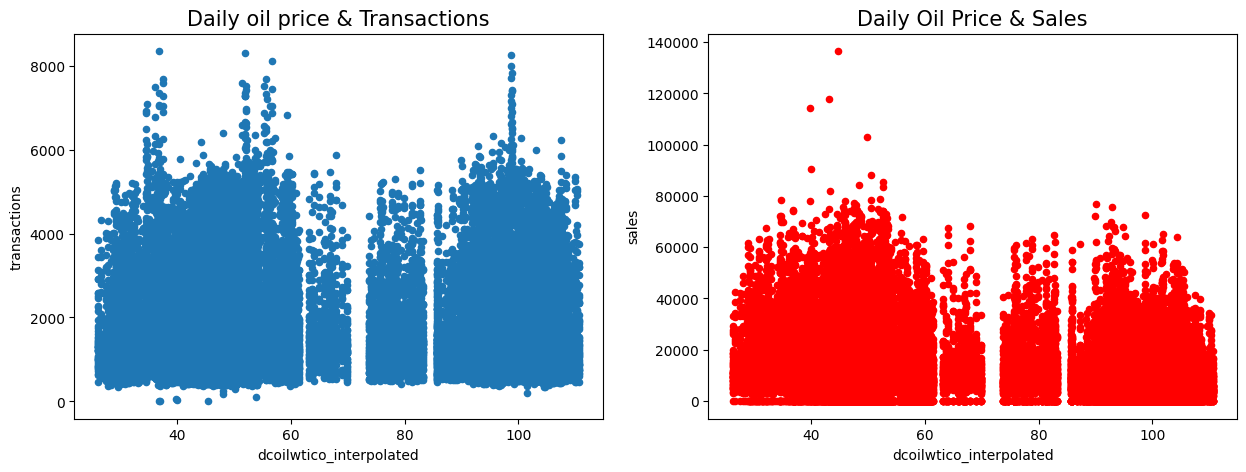

In [54]:
temp = pd.merge(temp, oil, how = "left")
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")


fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

# Here, we examine the correlation of oil price with transactions & sales.

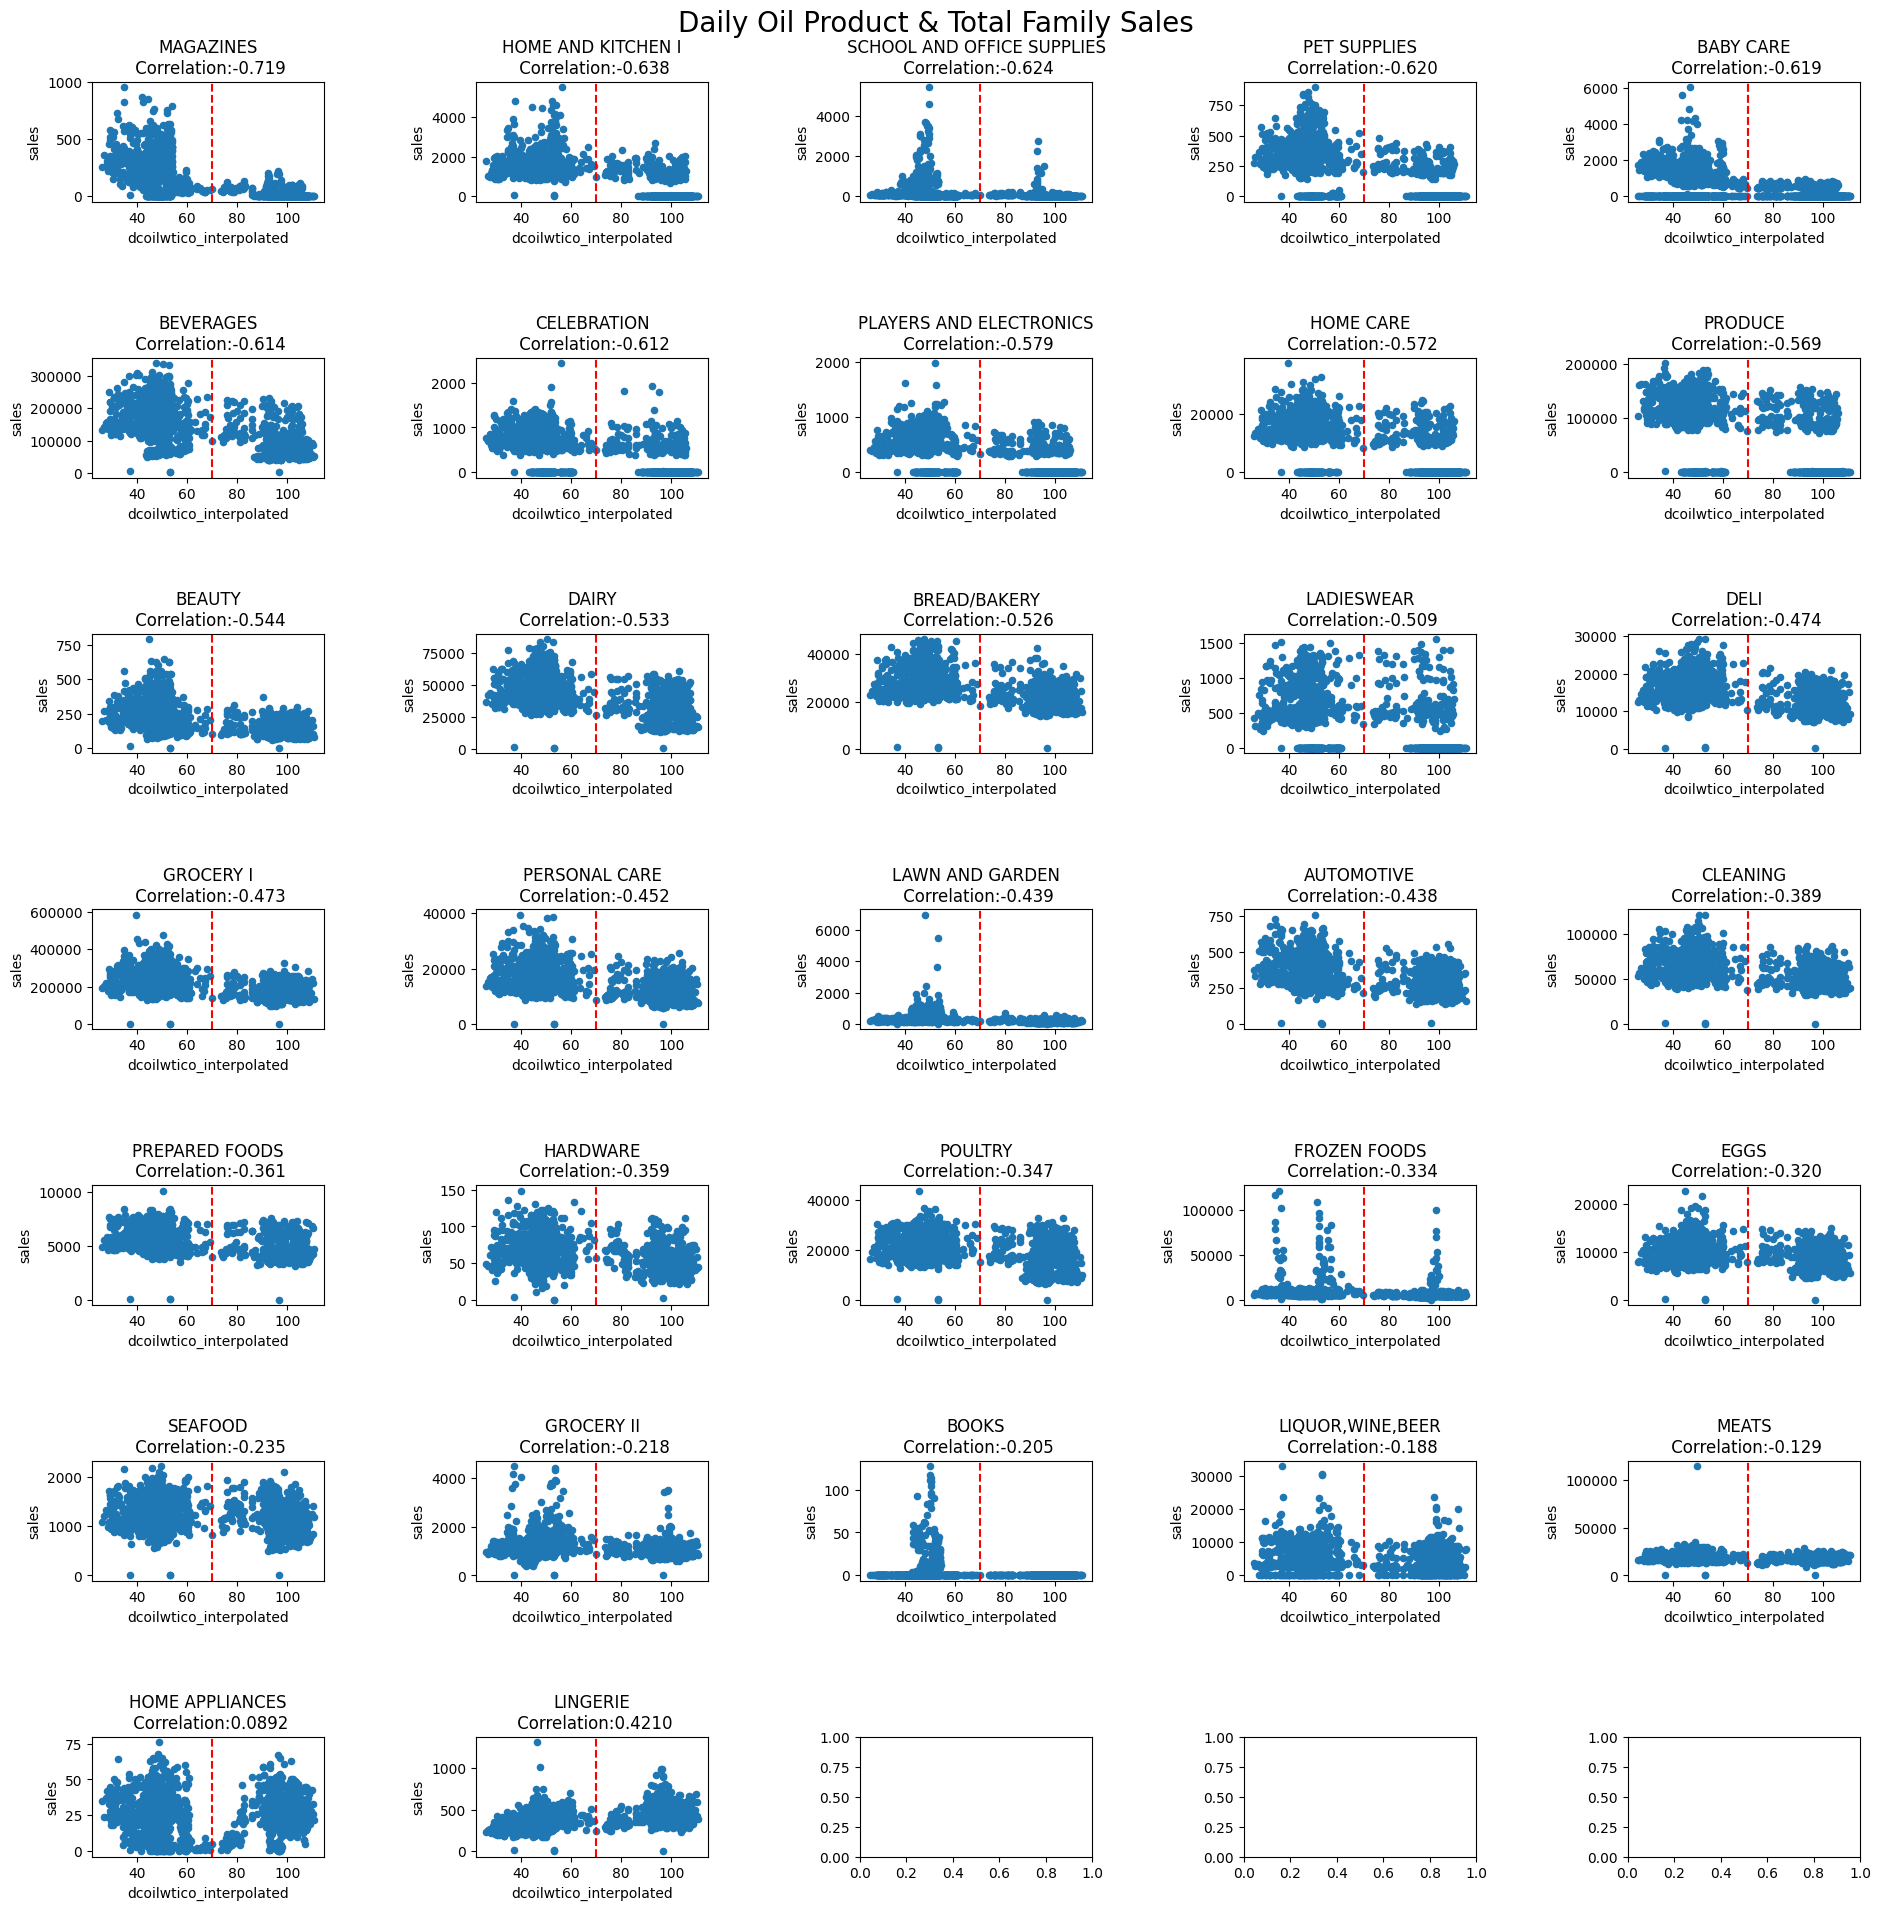

In [57]:
a = pd.merge(train.groupby(["date", "family"]).sales.sum().reset_index(), oil.drop("dcoilwtico", axis = 1), how = "left")
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

fig, axes = plt.subplots(7, 5, figsize = (20,20))
for i, fam in enumerate(c.family):
    if i < 6:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[0, i-1])
        axes[0, i-1].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[0, i-1].axvline(x=70, color='r', linestyle='--')
    if i >= 6 and i<11:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1, i-6])
        axes[1, i-6].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[1, i-6].axvline(x=70, color='r', linestyle='--')
    if i >= 11 and i<16:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[2, i-11])
        axes[2, i-11].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[2, i-11].axvline(x=70, color='r', linestyle='--')
    if i >= 16 and i<21:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[3, i-16])
        axes[3, i-16].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[3, i-16].axvline(x=70, color='r', linestyle='--')
    if i >= 21 and i<26:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[4, i-21])
        axes[4, i-21].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[4, i-21].axvline(x=70, color='r', linestyle='--')
    if i >= 26 and i < 31:
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[5, i-26])
        axes[5, i-26].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[5, i-26].axvline(x=70, color='r', linestyle='--')
    if i >= 31 :
        a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[6, i-31])
        axes[6, i-31].set_title(fam+"\n Correlation:"+str(c[c.family == fam].sales.iloc[0])[:6], fontsize = 12)
        axes[6, i-31].axvline(x=70, color='r', linestyle='--')


plt.tight_layout(pad=5)
plt.suptitle("Daily Oil Product & Total Family Sales \n", fontsize = 20);
plt.show()

# Here, we examine the correlation of oil price with sales of different product families